In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

In [2]:
from sklearn.model_selection import TimeSeriesSplit
df = pd.read_csv('train.csv', index_col=[0])

In [46]:
ori=pd.read_csv('feature_v1.csv', index_col = [0])

In [3]:
DATA_DIR = DATA_DIR = 'C:/Users/gybj0/Desktop/data'
df_files = pd.DataFrame(
    {'book_path': glob.glob(f'{DATA_DIR}/optiver_volatility/book_train.parquet/**/*.parquet')}) \
    .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')
df_target = pd.read_csv(f'{DATA_DIR}/optiver_volatility/train.csv')

def calc_rv(r):
    df = pd.read_parquet(r.book_path)
    df['wap'] = (df.ask_price1 * df.bid_size1 + df.bid_price1 * df.ask_size1) / (df.ask_size1 + df.bid_size1)
    df = df.groupby('time_id').wap.apply(lambda x: (np.log(x).diff() ** 2).sum() ** 0.5).reset_index()
    df.rename(columns={'wap': 'rv'}, inplace=True)
    df['stock_id'] = r.stock_id
    return df
    
df_rv_train = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

# Train, test, html split

In [10]:
time_ids = df.time_id_.factorize()[1]
time_indexes = df.time_id_.factorize()[0]
time_len = len(time_ids)
html_time = 0.1
train_time = time_ids[int((1 - html_time) * time_len)]

In [11]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


X_train = df[df.time_id_.apply(lambda x: x < train_time * 0.9)] 
X_test = df[df.time_id_.apply(lambda x: x > train_time * 0.9 and x < train_time)]
y_train, y_test = X_train.target, X_test.target

X_train.drop(['target'], axis = 1, inplace = True)
X_test.drop(['target'], axis = 1, inplace = True)

C:\Users\gybj0\AppData\Local\Temp\ipykernel_17988\2687647958.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['target'], axis = 1, inplace = True)
C:\Users\gybj0\AppData\Local\Temp\ipykernel_17988\2687647958.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['target'], axis = 1, inplace = True)


# Train NN

In [87]:
class TimeNeighbors:
    def __init__(self, name: str, n_neighbor: int, feature_pivot: pd.DataFrame):
        self.name = 'time_' + name
        feature_pivot = feature_pivot.pivot('time_id_','stock_id', name)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        nn = NearestNeighbors(n_neighbors = n_neighbor)
        nn.fit(feature_pivot)
        self.nn_ind = nn.kneighbors(feature_pivot, n_neighbors = n_neighbor, return_distance = False)
        self.time = X_train.time_id_.factorize()[0]
        self.stock = X_train.stock_id.factorize()[0]
        self.features = pd.DataFrame(feature_pivot.values[self.nn_ind[self.time, 1:n_neighbor], self.stock[:, None]])

class StockNeighbors:
    def __init__(self, name: str, n_neighbor: int, feature_pivot: pd.DataFrame):
        self.name = 'stock_' + name
        feature_pivot = feature_pivot.pivot('time_id_','stock_id', name)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        nn = NearestNeighbors(n_neighbors = n_neighbor)
        nn.fit(feature_pivot.T)
        self.nn_ind = nn.kneighbors(feature_pivot.T, n_neighbors = n_neighbor, return_distance = False)
        self.time = X_train.time_id_.factorize()[0]
        self.stock = X_train.stock_id.factorize()[0]
        self.features = pd.DataFrame(feature_pivot.T.values[self.nn_ind[self.stock, 1:n_neighbor], self.time[:, None]])

In [91]:
time_neighbors = [TimeNeighbors('wap1_mean', 10, X_train),
    TimeNeighbors('log_return_realized_volatility', 10, X_train),
    TimeNeighbors('size_sum', 10, X_train),
    TimeNeighbors('order_count_mean', 10, X_train),
    TimeNeighbors('volume_imbalance_mean', 10, X_train),
    TimeNeighbors('total_volume_mean', 10, X_train),
    TimeNeighbors('log_return1_mean', 10, X_train),]

stock_neighbors = [StockNeighbors('wap1_mean', 10, X_train),
    StockNeighbors('log_return_realized_volatility', 10, X_train)
    ]

In [89]:
def cal_ran_correaltion(neighbors):
    rank = pd.DataFrame()
    for n in neighbors:
        rank[n.name] = n.nn_ind.flatten()

    sns.heatmap(rank.corr(), annot = True)

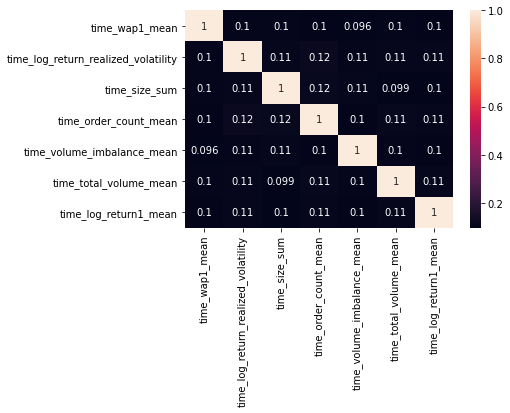

In [94]:
cal_ran_correaltion(time_neighbors)

KeyError: "None of ['time_id_', 'stock_id'] are in the columns"

In [60]:
pivot = X_train.pivot('time_id_','stock_id','total_volume_sum')
pivot = pivot.fillna(pivot.mean())
nn = NearestNeighbors(n_neighbors = 10)
nn.fit(pivot.T)
nn_ind = nn.kneighbors(pivot.T, n_neighbors = 10, return_distance = False)

In [72]:
time = X_train.time_id_.factorize()[0]
stock = X_train.stock_id.factorize()[0]

pd.DataFrame(pivot.T.values[nn_ind[stock, :10], time[:, None]])

,0,1,2,3,4,5,6,7,8,9
0,97365.0,63664.0,124530.0,108909.0,57630.0,30243.0,103985.0,85530.0,96655.0,83308.0
1,82290.0,98705.0,116328.0,81684.0,105094.0,27160.0,44901.0,55014.0,85633.0,113657.0
2,78274.0,79760.0,67900.0,96540.0,49991.0,64158.0,40207.0,77851.0,104537.0,67470.0
3,52232.0,98312.0,45762.0,132386.0,69478.0,61998.0,44342.0,96137.0,67374.0,46824.0
4,60407.0,119319.0,102224.0,63218.0,73664.0,31873.0,46302.0,68243.0,66295.0,79265.0
...,...,...,...,...,...,...,...,...,...,...
351074,39256.0,74549.0,88251.0,133937.0,73971.0,49881.0,88242.0,60127.0,63209.0,40331.0
351075,120523.0,105495.0,95992.0,165841.0,137689.0,79206.0,206781.0,151946.0,102031.0,153284.0
351076,47964.0,49757.0,97671.0,112933.0,74802.0,57370.0,101123.0,57382.0,79377.0,80706.0
351077,66543.0,78664.0,71297.0,101337.0,21773.0,95660.0,70696.0,28025.0,62265.0,50389.0


In [74]:
pivot

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
time_id_,,,,,,,,,,,,,,,,,,,,,
5,97365.0,165270.0,436695.0,204591.0,124530.0,29212.0,80507.0,110130.0,279967.0,90581.0,...,218578.0,181095.0,91731.0,1212674.0,435049.0,222796.0,386932.0,936075.0,1791966.0,96655.0
11,82290.0,120455.0,447859.0,139140.0,116328.0,99401.0,106848.0,64868.0,325002.0,91634.0,...,186197.0,75709.0,243109.0,1277634.0,460087.0,237034.0,313855.0,1046669.0,2099677.0,85633.0
16,78274.0,221013.0,475627.0,177197.0,67900.0,60530.0,247247.0,116957.0,247799.0,138886.0,...,146313.0,118516.0,81177.0,1591176.0,773253.0,209169.0,889452.0,2373965.0,1134310.0,104537.0
31,52232.0,71846.0,223493.0,98249.0,45762.0,40361.0,107053.0,174363.0,193933.0,135741.0,...,140760.0,47031.0,86137.0,994130.0,445404.0,200691.0,365033.0,785480.0,1425439.0,67374.0
62,60407.0,62896.0,274449.0,108167.0,102224.0,19037.0,104227.0,93658.0,278891.0,229756.0,...,126674.0,43887.0,44289.0,1572665.0,411322.0,281388.0,601669.0,882267.0,1377608.0,66295.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26277,74549.0,112324.0,366097.0,98641.0,73971.0,23037.0,91154.0,75058.0,145374.0,187990.0,...,138826.0,97692.0,117724.0,2523950.0,701880.0,247624.0,924041.0,1670826.0,2560232.0,39256.0
26292,105495.0,437992.0,231099.0,295848.0,137689.0,82409.0,393270.0,376959.0,243151.0,98231.0,...,266560.0,132946.0,134307.0,544618.0,409356.0,215983.0,455040.0,1723960.0,405575.0,120523.0
26307,49757.0,165939.0,360296.0,275007.0,74802.0,37527.0,166948.0,324884.0,323478.0,156220.0,...,111126.0,137593.0,78488.0,1880870.0,618304.0,265283.0,977855.0,1312243.0,1947053.0,47964.0


In [64]:
stock

array([  0,   0,   0, ..., 111, 111, 111], dtype=int64)

In [ ]:

nn = NearestNeighbors(algorithm = 'brute')
nn.fit(X_train)
nn_ind = nn.kneighbors(X_train, n_neighbors = 10, return_distance = False)

for nn_count in range(1, 11):
    time_ind = X_train.index.factorize()[0]
    
    train = pd.DataFrame(X_train.values[nn_ind[time_ind, :nn_count], stock_ind[:, None]])

    train.rename(lambda x: x, axis = 1, inplace = True)
    train.fillna(train.mean(), inplace = True)

    model = LinearRegression()
    scores = cross_val_score(model, train, y_train,
                            groups = X_train.time_id_,
                            scoring = make_scorer(rmspe),
                            fit_params = {'sample_weight': 1 / y_train ** 2})

    result.append({'nn_count': nn_count, 'score': scores.mean()})

df_results = pd.DataFrame(result)
ax = df_results.plot(x='nn_count', y='score', style='-C0o', figsize=(7, 5), legend=False)
best = df_results.iloc[df_results.score.argmin()]
plt.plot(best.nn_count, best.score, 'C3o', markersize=10)
plt.annotate(f'{best.score:.5f}', xy=(best.nn_count, best.score), xytext=(0, 10), 
            fontsize=12, textcoords='offset points', ha='center')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('CV score')
plt.title('How many nearest time_ids to take')